In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, Tuple

In [2]:
class GWOOptimizer:
    """
    Grey Wolf Optimizer (GWO) algorithm implementation.

    This class encapsulates the GWO algorithm, providing methods for initialization,
    optimization, and result retrieval.
    """

    def __init__(self, objective_function: Callable[[np.ndarray], float],
                 pop_size: int, max_iterations: int, lower_bound: float,
                 upper_bound: float, num_junctions : int, junctions_distance: int,
                 junction_length: int, avg_speed: int, seed: int = None):
        """
        Initialize the GWO optimizer.

        Args:
            objective_function (Callable): The function to be optimized.
            pop_size (int): Size of the wolf population.
            max_iterations (int): Maximum number of iterations.
            dimensions (int): Number of dimensions in the search space.
            lower_bound (float): Lower bound of the search space.
            upper_bound (float): Upper bound of the search space.
            seed (int, optional): Seed for random number generator. Defaults to None.
        """
        self.objective_function = objective_function
        self.pop_size = pop_size
        self.max_iterations = max_iterations
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.num_junctions = num_junctions
        self.dimensions = 3 * num_junctions
        self.junctions_distance = junctions_distance
        self.junction_length = junction_length
        self.avg_speed = avg_speed
        self.rng = np.random.default_rng(seed)

        self.alpha_pos = np.zeros(self.dimensions)
        self.alpha_score = np.inf
        self.beta_pos = np.zeros(self.dimensions)
        self.beta_score = np.inf
        self.delta_pos = np.zeros(self.dimensions)
        self.delta_score = np.inf

        self.positions = self._initialize_positions()
        self.convergence_curve = np.zeros(max_iterations)

    def _initialize_positions(self) -> np.ndarray:
        """Initialize the positions of wolves randomly within the specified bounds.

        Returns:
            np.ndarray: Randomly initialized positions of wolves.
        """
        return self.rng.uniform(self.lower_bound, self.upper_bound,
                                size=(self.pop_size, self.dimensions))

    def optimize(self) -> Tuple[float, np.ndarray, np.ndarray]:
        """Perform the optimization process.

        Returns:
            Tuple[float, np.ndarray, np.ndarray]: Best score, best position,
            and convergence curve.
        """
        for iteration in range(self.max_iterations):
            self._update_wolf_pack()
            self._update_positions(iteration)
            self.convergence_curve[iteration] = self.alpha_score

        return self.alpha_score, self.alpha_pos, self.convergence_curve

    def _update_wolf_pack(self):
        """Update alpha, beta, and delta wolves based on their fitness."""
        for i in range(self.pop_size):
            # Clip positions to stay within bounds
            self.positions[i] = np.clip(self.positions[i], 
                                         self.lower_bound, 
                                         self.upper_bound)
            fitness = self.objective_function(
                self.positions[i],
                self.num_junctions,
                self.junctions_distance,
                self.junction_length,
                self.avg_speed
            )

            # Update alpha, beta, and delta wolves based on fitness
            if fitness < self.alpha_score:
                self.delta_score, self.beta_score, self.alpha_score = (
                    self.beta_score, 
                    self.alpha_score, 
                    fitness
                )
                self.delta_pos, self.beta_pos, self.alpha_pos = (
                    self.beta_pos.copy(), 
                    self.alpha_pos.copy(), 
                    self.positions[i].copy()
                )
            elif fitness < self.beta_score:
                self.delta_score, self.beta_score = (
                    self.beta_score, 
                    fitness
                )
                self.delta_pos, self.beta_pos = (
                    self.beta_pos.copy(), 
                    self.positions[i].copy()
                )
            elif fitness < self.delta_score:
                self.delta_score = fitness
                self.delta_pos = self.positions[i].copy()

    def _update_positions(self, iteration: int):
        """Update positions of all wolves based on the GWO algorithm.

        Args:
            iteration (int): Current iteration number.
        """
        a = 2 - 2 * (iteration / self.max_iterations)

        for i in range(self.pop_size):
            # Calculate new position for each wolf
            self.positions[i] = self._calculate_new_position(self.positions[i], a)

    def _calculate_new_position(self, current_pos: np.ndarray, a: float) -> np.ndarray:
        """Calculate the new position for a wolf.

        Args:
            current_pos (np.ndarray): Current position of the wolf.
            a (float): Coefficient influencing position update.

        Returns:
            np.ndarray: New position of the wolf.
        """
        A1, C1 = self._get_a_c_coefficients(a)
        X1 = (self.alpha_pos - A1 * 
               np.abs(C1 * self.alpha_pos - current_pos))

        A2, C2 = self._get_a_c_coefficients(a)
        X2 = (self.beta_pos - A2 * 
              np.abs(C2 * self.beta_pos - current_pos))

        A3, C3 = self._get_a_c_coefficients(a)
        X3 = (self.delta_pos - A3 * 
              np.abs(C3 * self.delta_pos - current_pos))

        return (X1 + X2 + X3) / 3

    def _get_a_c_coefficients(self, a: float) -> Tuple[float, float]:
        """Calculate A and C coefficients for position update.

        Args:
            a (float): Coefficient influencing position update.

        Returns:
            Tuple[float, float]: A and C coefficients.
        """
        r1, r2 = self.rng.random(2)
        A = 2 * a * r1 - a
        C = 2 * r2
        return A, C

In [3]:
# Constants
NUM_JUNCTIONS = 8
JUNCTIONS_DISTANCE = 800  # meters
JUNCTION_LENGTH = 40  # meters
AVG_SPEED = 20

# Bounds for light timings (in seconds)
MIN_TIME = 5
MAX_TIME = 120

# Set up and run the GWO optimizer
pop_size = 30
max_iterations = 100
dimensions = 3 * NUM_JUNCTIONS  # 3 timing variables for each junction

In [4]:
def traffic_light_objective(x, num_junctions, junction_distance, junction_length, avg_speed):
    """
    Objective function for traffic light optimization.
    
    Args:
    x (np.array): Array of shape (3, num_junctions) containing the timing for each light color
                  at each junction. x[0] is red, x[1] is yellow, x[2] is green.
    num_junctions (int): Number of junctions in the system.
    junction_distance (float): Distance between junctions in meters.
    junction_length (float): Length of each junction in meters.
    avg_speed (float): Average speed of cars in meters per second.
    
    Returns:
    float: The total travel time through all junctions.
    """
    
    # Ensure valid timings (all positive and sum to a reasonable cycle time)
    if np.any(x < 0) or np.any(np.sum(x, axis=0) < 30) or np.any(np.sum(x, axis=0) > 180):
        return np.inf
    
    total_time = 0
    
    for i in range(num_junctions):
        red_time, yellow_time, green_time = x[:, i]
        cycle_time = red_time + yellow_time + green_time
        
        # Time to travel to the junction
        travel_time = junction_distance / avg_speed
        
        # Average waiting time at the junction (assuming uniform arrival distribution)
        avg_wait_time = (red_time ** 2 + yellow_time ** 2) / (2 * cycle_time)
        
        # Time to cross the junction
        crossing_time = junction_length / avg_speed
        
        # Total time for this junction
        junction_time = travel_time + avg_wait_time + crossing_time
        
        total_time += junction_time
    
    # Penalty for lack of coordination between adjacent lights
    for i in range(num_junctions - 1):
        time_diff = abs(np.sum(x[:, i]) - np.sum(x[:, i+1]))
        total_time += 0.1 * time_diff  # Small penalty for uncoordinated lights
    
    return total_time

In [5]:
def wrapper_objective(
    x: np.ndarray,
    num_junctions,
    junctions_distance,
    junction_length,
    avg_speed: int
) -> float:
    """
    Wrapper function to reshape the 1D input from GWO into the 2D array 
    expected by the traffic light objective function.
    """
    reshaped_x = x.reshape(3, num_junctions)
    return traffic_light_objective(reshaped_x, num_junctions, junctions_distance, junction_length, avg_speed)

In [6]:
gwo = GWOOptimizer(
    objective_function=wrapper_objective,
    pop_size=pop_size,
    max_iterations=max_iterations,
    lower_bound=MIN_TIME,
    upper_bound=MAX_TIME,
    num_junctions=NUM_JUNCTIONS,
    junctions_distance=JUNCTIONS_DISTANCE,
    junction_length=JUNCTION_LENGTH,
    avg_speed=AVG_SPEED
)

In [7]:
best_score, best_position, convergence_curve = gwo.optimize()

In [8]:
# Reshape the best position into the traffic light timings
optimal_timings = best_position.reshape(3, NUM_JUNCTIONS)

In [9]:
# Create a DataFrame for optimal traffic light timings
data = {
    'Junction': [f'Junction {i+1}' for i in range(NUM_JUNCTIONS)],
    'Red': optimal_timings[0],
    'Yellow': optimal_timings[1],
    'Green': optimal_timings[2]
}

df_timings = pd.DataFrame(data)

# Display the results
print("Optimization complete!")
print(f"Best score (total travel time): {best_score:.2f} seconds")
print("\nOptimal traffic light timings:")
display(df_timings)

Optimization complete!
Best score (total travel time): 372.56 seconds

Optimal traffic light timings:


,Junction,Red,Yellow,Green
0,Junction 1,9.663247,11.652704,11.223489
1,Junction 2,11.432624,13.771116,7.866257
2,Junction 3,13.782530,16.554544,6.886726
3,Junction 4,9.738461,12.633686,7.831819
4,Junction 5,15.667989,11.806316,14.870567
5,Junction 6,13.409194,7.980690,17.874633
6,Junction 7,11.958038,8.583259,9.944203
7,Junction 8,10.698184,7.834186,11.473624


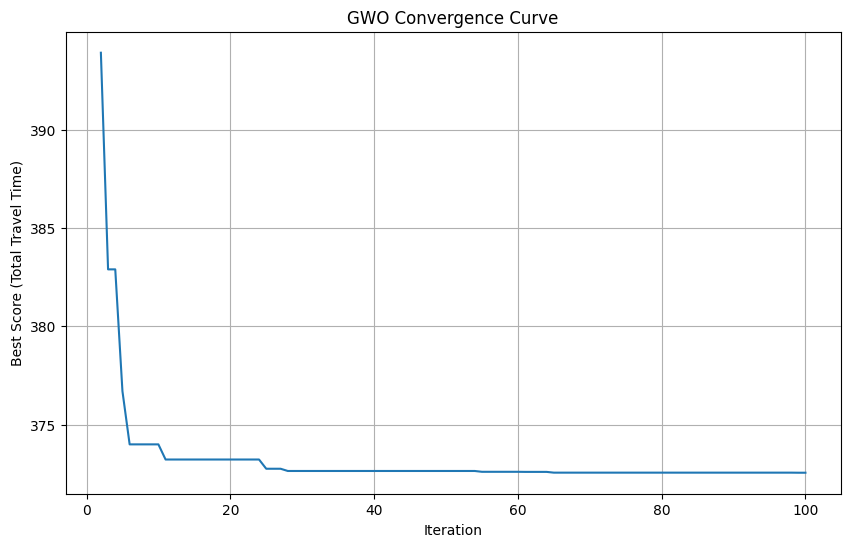

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), convergence_curve)
plt.title('GWO Convergence Curve')
plt.xlabel('Iteration')
plt.ylabel('Best Score (Total Travel Time)')
plt.grid(True)
plt.show()

In [11]:
#Compare the travel time accross number of junctions.

num_junctions_list = []
scores = []

for num_junctions in range(1, 101):
    gwo = GWOOptimizer(
        objective_function=wrapper_objective,
        pop_size=pop_size,
        max_iterations=max_iterations,
        lower_bound=MIN_TIME,
        upper_bound=MAX_TIME,
        num_junctions=num_junctions,
        junctions_distance=JUNCTIONS_DISTANCE,
        junction_length=JUNCTION_LENGTH,
        avg_speed=AVG_SPEED
    )
    best_score, best_position, convergence_curve = gwo.optimize()

    num_junctions_list.append(num_junctions)
    scores.append(best_score)

print("Calculating done!")

Calculating done!


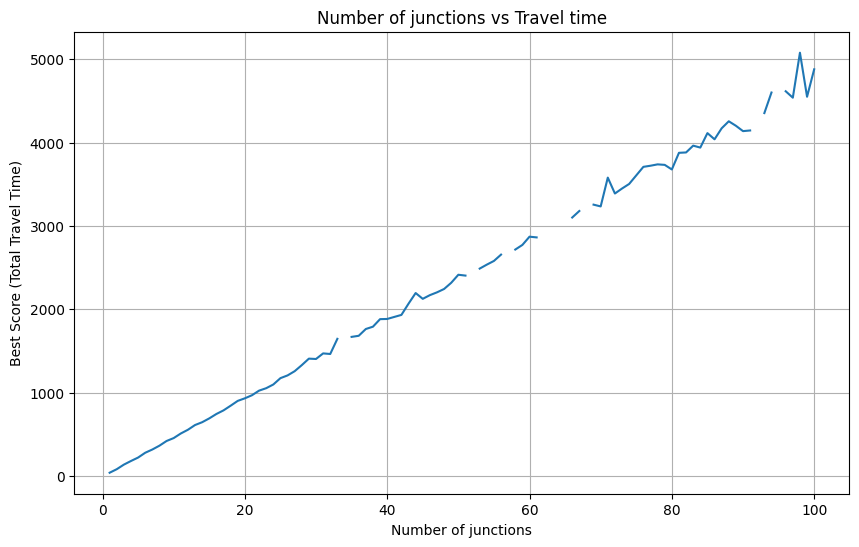

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(num_junctions_list, scores)
plt.title('Number of junctions vs Travel time')
plt.xlabel('Number of junctions')
plt.ylabel('Best Score (Total Travel Time)')
plt.grid(True)
plt.show()